In [1]:
import os 
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import warnings
from Useful_Modules import (read_transfer, read_k_file, _get_Cl_cmb)
from SGWB_Signal import Signal_GW
from scipy import optimize
import tools_LiteBIRD
from numba import njit
import seaborn as sns
import healpy as hp
from iminuit import Minuit
from iminuit import minimize as mntminimize


In [2]:
R = 0.
FSKY = 0.9 # sky fraction, remember to change it when running different sky cuts
LMIN = 2
LMAX = 191
CURRENT_PATH = op.abspath('')
TRANSFERFILE = CURRENT_PATH+'/ancillary_files/Tensor_Transfer_Function_Bpol_starobinsky'
K_FILE = CURRENT_PATH+'/ancillary_files/colonnetensor_starobinsky.dat'
A_S = 2.1e-9
k_0 = 0.05
Delta3 = read_transfer(TRANSFERFILE)    
ks, pows, measures = read_k_file(K_FILE)
pows = R * A_S * (ks/k_0)**(-R/8)  # tensor spectrum for choice of r and n_T
ell = np.arange(LMIN, LMAX+1)
norm_ell = ell*(ell+1)/2/np.pi
lensing = _get_Cl_cmb(1.0, 0.0)[2][LMIN:LMAX+1]  # pure lensing Cls


In [3]:
Cls_QML = np.load('allcl_whitenoise_fsky0.9401041666666666_thresh_0.1_field_5.npy')[:, 1, :]
Cls_pseudo = np.load('Pseudocls_whitenoise_apo10.0_C2_PL_fsky_0.9597731317379207_binned.npy')


In [5]:
# beam 
beam = 80 # [arcmin]
fwhm = beam/60. # [deg]

# up to which multipole to use QML (must be lesser or equal to 2*N_side of the QML maps)
lmax_qml = 16
# concatenate QML for ell <lmax_qml and pseudo Cl for ell>lmax_qml
Cls_out_BB = np.concatenate((Cls_QML[:, :lmax_qml], Cls_pseudo[:, lmax_qml:]), axis=1)


In [6]:
num_samples = len(Cls_out_BB[:, 0])  # number of simulations
lenght_sample = len(Cls_out_BB[0])  # ell max of simulations

ell_binned = np.array([2. ,   3. ,   4. ,   5. ,   6. ,   7. ,   8. ,   9. ,  10. ,
        11. ,  12. ,  13. ,  14. ,  15. ,  16. ,  17. ,  18. ,  19. ,
        20. ,  21. ,  22. ,  23. ,  24. ,  25. ,  26. ,  27. ,  28. ,
        29. ,  30. ,  31. ,  32. ,  33. ,  34. ,  35. ,  40.5,  50.5,
        60.5,  70.5,  80.5,  90.5, 100.5, 110.5, 120.5, 130.5, 140.5])


In [7]:
# Compute mean from simulations
mean = np.zeros(lenght_sample)
for i in range(num_samples):
    mean += Cls_out_BB[i]
mean = mean/num_samples


In [8]:
def f_Cell(r, nT):
    """
    Computes Cl^BB for Single-field Slow-Roll inflation model.
    """
    FACTOR = 7.42835025e12  # units Cls
    class_gw = Signal_GW(r_vac=r, nT=nT, axion=None)
    pows = class_gw.tensor_spect(ks)
    #print(pows)
    ClBB = call_Cl(pows)
    ClBB = np.array(ClBB)
    ClBB = (np.pi)/4.0 * FACTOR * ClBB
    return ClBB


@njit
def call_Cl(pows):
    """
    Computes Cl^BB given primordial tensor power spectrum.
    """
    qmax = len(measures)
    ClBB = [0.0]*(LMAX-1)
    for j in range(0, len(ClBB)):  # use einsum for faster loop?
        for q_ix in range(0, qmax):
            ClBB[j] = ClBB[j] + pows[q_ix]*((Delta3[j][q_ix])**2)*measures[q_ix]
    return ClBB


def Nell(depth_p, fwhm, lmax):
    """
    Computes Cl^BB for Single-field Slow-Roll inflation model.
    """
    bl = hp.gauss_beam(np.radians(fwhm/60.), lmax=lmax+1, pol=True)[:,2] 
    nl = (np.radians(depth_p/60.) / np.array(bl))**2 
    return nl[2:]


In [9]:
# Compute cov matrix from simulations
clfid = mean

# take only 500 of the 1000 sims to compute the covariance and 500 as data
num_samples=500

# compute covariance matrix 
Cov = np.zeros((lenght_sample, lenght_sample))
for _ell in range(lenght_sample):
    for _ell_prime in range(lenght_sample):
        for i in range(num_samples):
            vec_ell = (Cls_out_BB[i][_ell] - clfid[_ell])
            vec_ell_prime = (Cls_out_BB[i][_ell_prime] - clfid[_ell_prime])
            Cov[_ell, _ell_prime] += vec_ell * vec_ell_prime
Cov = Cov/(num_samples)


In [10]:
# initialize binning
bins = tools_LiteBIRD.get_binning()

In [11]:
# bin covariance matrix
cbcov = Cov #  binned covariance matrix 
invclcov = np.linalg.inv(cbcov)

# diagonal of binned covariance for offset calculation
clvar = np.diag(cbcov).reshape(-1, bins.nbins) 

# offset
cloff = tools_LiteBIRD.compute_offsets(bins.lbin, clvar, clfid, fsky=FSKY)


In [12]:
def _offsetHL_fit_SFSR(r, cldata, cloff, clfid, invclcov, ell_range=None, muKarcmin=10):
    """
    Compute offset-Hamimeche & Lewis likelihood with Sellentin & Heavens 
    correction, as written in the LoLLiPoP likelihood (Tristram et al. 2021),
    modified for auto-spectra (includes noise bias).
    
    Fits tensor-to-scalar ratio r to data.
    """
    ell_range_loc = ell_range
    nt = -r/8
    
    # sampled Cls
    cl = f_Cell(r, nt) + lensing + Nell(muKarcmin, beam, 190) #  lensed theory being varied
    cl = np.insert(cl, 0, 0.0)
    cl = np.insert(cl, 0, 0.0)
    clth = bins.bin_spectra(cl) 
    
    # slice reionization bump multipole range
    if ell_range_loc=='reio':
        lmax_reio = 20-LMIN+1
        clth = clth[:lmax_reio]    
        cldata_loc = cldata[1][:lmax_reio]
        clfid_loc = clfid[1][:lmax_reio]
        cloff_loc = cloff[1][:lmax_reio]
        invclcov_loc = invclcov[:lmax_reio, :lmax_reio]
    
    # slice recombination bump multipole range
    elif ell_range_loc=='rec':
        lmin_rec = 20#-LMIN+1
        clth = clth[lmin_rec:]    
        cldata_loc = cldata[1][lmin_rec:]
        clfid_loc = clfid[1][lmin_rec:]
        cloff_loc = cloff[1][lmin_rec:]
        invclcov_loc = invclcov[lmin_rec:, lmin_rec:]
    
    # else full ell range
    else:
        cldata_loc = cldata[1]
        clfid_loc = clfid
        cloff_loc = cloff[0]
        invclcov_loc = invclcov
        
    x = (cldata_loc + cloff_loc) / (clth + cloff_loc)
    g = np.sign(x) * tools_LiteBIRD.ghl(np.abs(x))
    
    X = (np.sqrt(clfid_loc + cloff_loc)) * g * (np.sqrt(clfid_loc + cloff_loc))
    
    chi2 = X @ invclcov_loc @ X
    # now implement SH correction
    Nsim = 500
    chi2_SH = -2*np.log((1 + chi2/(Nsim - 1))**(-Nsim/2)) 
    return chi2_SH


In [13]:
# full range
ell_range = None
x0 = (0.0,) # starting value of r for minimization
bounds = ((-0.01, 0.044),) # range of r for bounded minimization
success_full = [] # take note of succesfull or unsuccesfull minimizations and later exclude the failed ones
r_full = np.zeros((num_samples, 1)) # array of maximum likelihood r values
for i in range(num_samples):
    print('REALIZATION NUMBER = ', i)
    cldata = np.zeros((3, 45))
    cldata[1] = Cls_out_BB[i+499] 
    popt = mntminimize(_offsetHL_fit_SFSR, 
                        x0, 
                        args=(cldata, cloff, clfid, invclcov, ell_range),
                        bounds=bounds, 
                        )
    success_full.append(popt.success)
    r_full[i] = popt['x']


REALIZATION NUMBER =  0
REALIZATION NUMBER =  1
REALIZATION NUMBER =  2
REALIZATION NUMBER =  3
REALIZATION NUMBER =  4
REALIZATION NUMBER =  5
REALIZATION NUMBER =  6
REALIZATION NUMBER =  7
REALIZATION NUMBER =  8
REALIZATION NUMBER =  9
REALIZATION NUMBER =  10
REALIZATION NUMBER =  11
REALIZATION NUMBER =  12
REALIZATION NUMBER =  13
REALIZATION NUMBER =  14
REALIZATION NUMBER =  15
REALIZATION NUMBER =  16
REALIZATION NUMBER =  17
REALIZATION NUMBER =  18
REALIZATION NUMBER =  19
REALIZATION NUMBER =  20
REALIZATION NUMBER =  21
REALIZATION NUMBER =  22
REALIZATION NUMBER =  23
REALIZATION NUMBER =  24
REALIZATION NUMBER =  25
REALIZATION NUMBER =  26
REALIZATION NUMBER =  27
REALIZATION NUMBER =  28
REALIZATION NUMBER =  29
REALIZATION NUMBER =  30
REALIZATION NUMBER =  31
REALIZATION NUMBER =  32
REALIZATION NUMBER =  33
REALIZATION NUMBER =  34
REALIZATION NUMBER =  35
REALIZATION NUMBER =  36
REALIZATION NUMBER =  37
REALIZATION NUMBER =  38
REALIZATION NUMBER =  39
REALIZATIO

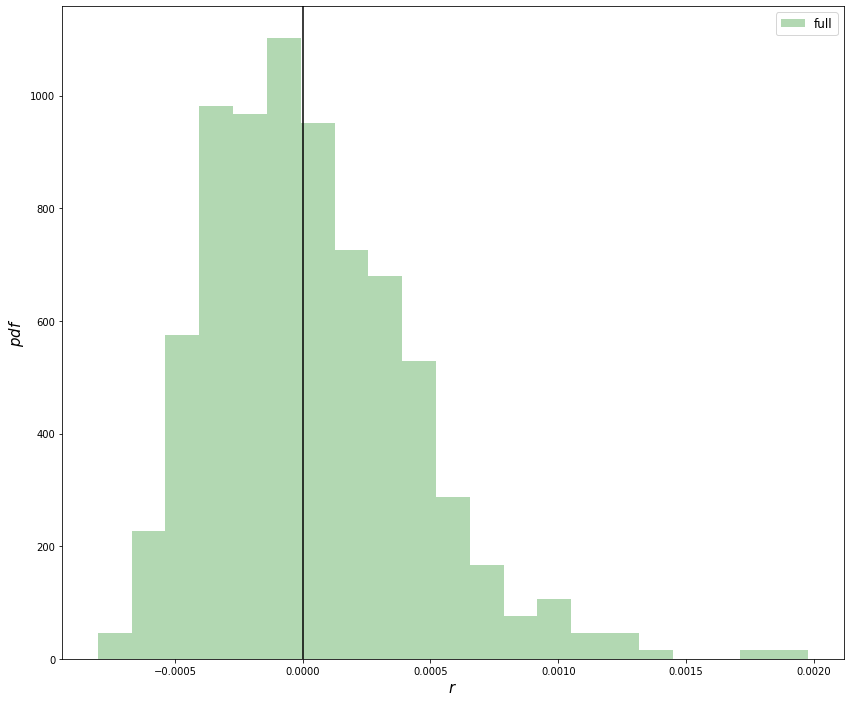

median r -2.23603853512401e-05
mean r 3.348041390743109e-05
std r 0.0003980942760432173
err on the mean  1.7803317253723996e-05


In [14]:
r_val_full = r_full[:,0]

# fitted r histogram
fig = plt.figure(figsize=(14,12), facecolor='w', edgecolor='k')
ax = plt.gca()
plt.hist(r_val_full, bins='auto', color='green', label='full', alpha=0.3, density=True)
plt.axvline(x=0, color='black')
plt.xlabel('$r$', fontsize=15)
plt.ylabel('$pdf$', fontsize=15)
plt.legend(prop={'size': 12})
plt.show()

# compute median, mean, std, error on the mean
# for the parameter r  
N_sims = num_samples
r_input = 0.
r_val = r_full[:,0]
median_r = np.median(r_val)
mean_r = np.mean(r_val)
std_r = np.std(r_val)
err_mean = std_r/np.sqrt(N_sims)
print('median r', median_r)
print('mean r', mean_r)
print('std r', std_r)
print('err on the mean ', err_mean)


[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,